# Neuronová síť s jednou vrstvou "skrytých" neuronů

Výstup každého neuronu je vypočten jako
$$
 o_k = f(\sum_j w_{kj} i_j + b_k)
$$

Neuronová síť s jednou vrstvou skrytých neuronů je tedy možné popsat pomocí matice $A^1$ a vektoru $b^1$ popisující přechod mezi vstupní a skrytou vrstvou neuronů a matice $A^2$ a vektoru $b^2$ pro přechod mezi skrytou a výstupní vrstvou.

Síť je tedy popsána čtveřicí
$$
    w = [ A^1, b^1, A^2, b^2 ]
$$

In [1]:
using Knet
using GZip
using Compat

## Aktivační funkce

In [2]:
f(z) = max(z, 0.0) + 0.01*min(z,0.0)

f (generic function with 1 method)

In [3]:
# Výpočet výstupních hodnot pro zadanou síť w a vstupní data x

function predict(w,x)
    for i=1:2:length(w)
        x = f.(w[i]*x .+ w[i+1])
    end
    return x
end

predict (generic function with 1 method)

## Chyba predikce

Pro výpočet chyby použijeme $||predict(w,x) - y^*||^2$, kde $y^*$ je správné řešení

In [4]:
function loss(w,x,ygold)
    ypred = predict(w,x)
    sum( (ypred-ygold).^2 )
end

loss (generic function with 1 method)

## Metoda největšího spádu

Učení provedeme pomocí metody největšího spádu
$$
  w^{n+1} = w^n - \alpha \frac{\partial loss(w^n, x_n, y^*_n)}{\partial w^n}
$$
kde $x_n$ a $y^*_n$ jsou z trénovací množiny. 

In [5]:
lossgradient = grad(loss)

(::gradfun) (generic function with 1 method)

In [6]:
function train(w, dtrn; lr=.5, epochs=10)
    for epoch=1:epochs
        for (x,y) in dtrn
            g = lossgradient(w, x, y)
            for i in 1:length(w)
                # w[i] -= lr * g[i]
                axpy!(-lr, g[i], w[i])
            end
        end
    end
    return w
end

train (generic function with 1 method)

## Posouzení kvality sítě

In [7]:
# Převod výstupu na číslo
decode(y) = findmax(y)[2] - 1

decode (generic function with 1 method)

In [8]:
function accuracy(w, dtst)
    ncorrect = 0
    for (x, ygold) in dtst
        correct = decode(ygold)
        guess = decode( predict(w, x) )
        
        if guess==correct
            ncorrect += 1
        end
    end
    return ncorrect/length(dtst)
end

accuracy (generic function with 1 method)

## Inicializace sítě pomocí náhodných vah

Sestavujeme množinu $2(m+1)$ parametrů popisující sít ($m$ je počet skrytých vrstev). Vstupní vrstva má fixní velikost $28*28=784$ neuronů, velikosti skrytých vrstev se zadávají jako parametr/parametry a výstupní vrstva má 10 neuronů. 

In [9]:
function weights(h...; atype=Array{Float32}, winit=0.1)
    w = Any[]
    x = 28*28
    for y in [h..., 10]
        push!(w, convert(atype, winit*randn(y,x)))
        push!(w, convert(atype, zeros(y, 1)))
        x = y
    end
    return w
end

weights (generic function with 1 method)

## Načtení sérií dat pro učení a testování

- *xtrn* obsahuje vstupní data pro učení (60000 skenovaných číslic v rastru 28x28)
- *ytrn* obsahuje správné výsledky pro učení
- *xtst* obsahuje vstupní data pro testování (10000 skenovaných číslic)
- *ytst* obsahuje správné výsledky pro testovací data

Sady dat načteme a přeorganizujeme je do pole dvojic (x,y)

In [10]:
function loaddata()
    global xtrn,ytrn,xtst,ytst
    info("Loading MNIST...")
    xtrn = gzload("train-images-idx3-ubyte.gz")[17:end]
    xtst = gzload("t10k-images-idx3-ubyte.gz")[17:end]
    ytrn = gzload("train-labels-idx1-ubyte.gz")[9:end]
    ytst = gzload("t10k-labels-idx1-ubyte.gz")[9:end]
end

function gzload(file; path=Knet.dir("data",file), url="http://yann.lecun.com/exdb/mnist/$file")
    isfile(path) || download(url, path)
    f = gzopen(path)
    a = @compat read(f)
    close(f)
    return(a)
end

gzload (generic function with 1 method)

In [11]:
function rearange(x, y)
    xa = convert(Array{Float32}, reshape(x, 784, div(length(x),784) ) ) ./ 255
    ya = zeros(10,size(xa,2))
    for i=1:size(xa,2)
        ya[y[i]+1,i] = 1.0
    end
    
    data = Any[]
    for i =1:size(xa,2)
        push!(data, (xa[:,i], ya[:,i]) )
    end
    return data
end

rearange (generic function with 1 method)

In [12]:
loaddata();

INFO: Loading MNIST...


In [13]:
dtrn = rearange(xtrn, ytrn);
dtst = rearange(xtst, ytst);

In [14]:
using PyPlot

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
5

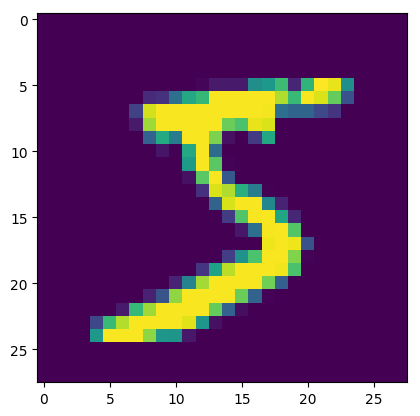

In [15]:
imshow(reshape(dtrn[1][1],28,28)')
println(dtrn[1][2])
println(decode(dtrn[1][2]))

## Inicializace sítě s jednou skrytou vrstvou o 64 neuronech

In [16]:
w = weights(64);

In [17]:
accuracy(w,dtst)

0.0802

## Učení sítě 

In [18]:
for epoch = 1:4
    train(w, dtrn; lr=0.01, epochs=1);
    println(accuracy(w, dtst))
end

0.9556
0.9602
0.9638
0.9676


In [19]:
accuracy(w,dtst)

0.9676

## Výsledky

In [20]:
[predict(w, dtst[1][1])  dtst[1][2]]

10×2 Array{Float64,2}:
 -0.00660753  0.0
 -0.0029043   0.0
 -0.00683846  0.0
 -0.00590785  0.0
 -0.0159409   0.0
 -0.00354447  0.0
 -0.0102652   0.0
  0.781139    1.0
 -0.00825619  0.0
 -0.0124399   0.0

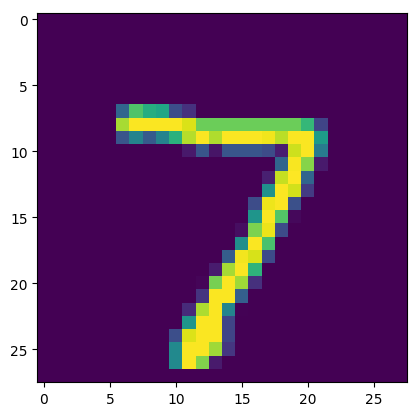

7

In [21]:
imshow(reshape(dtst[1][1], 28,28)')
decode( predict(w, dtst[1][1]) )

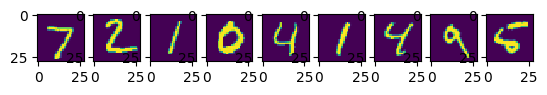

In [22]:
for i=1:9
    subplot(190+i); imshow(reshape(dtst[i][1], 28,28)')
end

In [23]:
println("Odhad   : ", [decode(predict(w,dtst[i][1])) for i=1:9])
println("Spravne : ", [decode(dtst[i][2]) for i=1:9])

Odhad   : [7, 2, 1, 0, 4, 1, 4, 9, 5]
Spravne : [7, 2, 1, 0, 4, 1, 4, 9, 5]
